In [1]:
import json
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import skimage.io
import scipy.ndimage, scipy
import os
from multiprocessing import Pool
from PIL import Image, ImageDraw
import glob

%matplotlib inline

In [7]:
def show_image(url):
    f = urllib.request.urlopen(url)
    img = plt.imread(f, "jpeg")
    plt.imshow(img)

def show_polygon(polygon):
    pts = []
    outline = polygon[0]
    for i in range(len(outline)//2):
        pts.append((outline[i*2], outline[i*2+1]))
    act = [Path.LINETO] * len(pts)
    act[0] = Path.MOVETO
    act[-1] = Path.CLOSEPOLY
    path = Path(pts, act)
    patch = patches.PathPatch(path, facecolor='orange', lw=2)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.add_patch(patch)

def object_mask(segmentation, img):
    img = Image.new('L', (img['width'], img['height']), 0)
    ImageDraw.Draw(img).polygon(segmentation[0], outline=1, fill=1)
    # cut out
    for polygon in segmentation[1:]:
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=0)
    mask = np.array(img)
    return mask

def object_mask_combined(segmentations, img):
    mask = np.zeros((img['height'], img['width']), dtype = np.int32)
    for segmentation in segmentations:
        mask = mask + object_mask(segmentation, img)
    np.clip(mask, 0, 1, out=mask)
    return mask

def get_best_range_of_instance(mask, img):
    """Returns best range to capture the instance. Return
    (x, y, length)"""
    length = min(img['height'], img['width'])
    if img['height'] > length:
        # 5 pixel before start.
        first_masked = np.any(mask > 0, axis=1).tolist().index(True)
        y = min(max(first_masked - 5, 0), img['height'] - length - 1)
        return (0, y, length)
    elif img['width'] > length:
        # 5 pixel before start.
        first_masked = np.any(mask > 0, axis=0).tolist().index(True)
        x = min(max(first_masked - 5, 0), img['width'] - length - 1)
        return (x, 0, length)
    else:
        return (0, 0, length)

def get_range_max_sqare(img):
    """Returns a square in the center of image. Return
    (x, y, length)"""
    length = min(img['height'], img['width'])
    if img['height'] > length:
        y = (img['height'] - length) // 2
        return (0, y, length)
    elif img['width'] > length:
        x = (img['width'] - length) // 2
        return (x, 0, length)
    else:
        return (0, 0, length)
    
def crop(startx, starty, length, imgarray):
    return imgarray[starty : starty + length, startx : startx + length]

def crop_seg_and_save(segmentations, img, basedir = 'data/train2014', target_prefix = 'data/human_t'):
    mask = object_mask_combined(segmentations, img)
    rng = get_best_range_of_instance(mask, img)
    fn = img['file_name']
    img_data = skimage.io.imread(os.path.join(basedir, fn))
    img_data = crop(rng[0], rng[1], rng[2], img_data)
    skimage.io.imsave(os.path.join(target_prefix, fn), img_data)
    
def crop_square_and_save(img, basedir = 'data/train2014', target_prefix = 'data/human_f'):
    rng = get_range_max_sqare(img)
    fn = img['file_name']
    img_data = skimage.io.imread(os.path.join(basedir, fn))
    img_data = crop(rng[0], rng[1], rng[2], img_data)
    skimage.io.imsave(os.path.join(target_prefix, fn), img_data)

## Create a list of images that contain people.

In [5]:
with open('data/mscoco/person_keypoints_train2014.json', 'r') as inp:
    d = json.load(inp)

In [10]:
# Merge all people polygons in each image.
img_id_to_people = dict() # image -> polygons
for people in d['annotations']:
    if people['iscrowd'] == 1:
        continue
    polygons = img_id_to_people.get(people['image_id'], [])
    if not type(people['segmentation']) is list:
        print(people)
        raise Exception()
    polygons.append(people['segmentation'])
    img_id_to_people[people['image_id']] = polygons
    
# Build map from id to file name
img_id_to_image = dict()
for img in d['images']:
    img_id_to_image[img['id']] = img
    
valid_id = set(img_id_to_image.keys()) & set(img_id_to_people.keys())

### Print some example IDs.

In [11]:
print(list(valid_id)[:10])

[262145, 262146, 524291, 393223, 393224, 524297, 393227, 131084, 393230, 524311]


### Take a look at how a mask look like

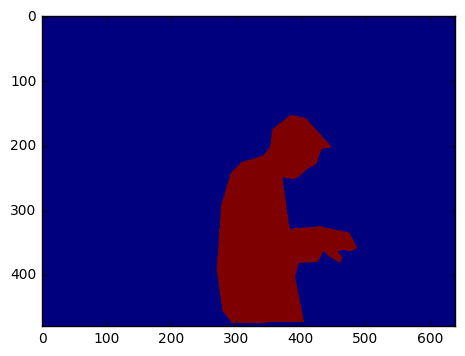

In [12]:
mask = object_mask_combined(img_id_to_people[524311], img_id_to_image[524311])
plt.imshow(mask)

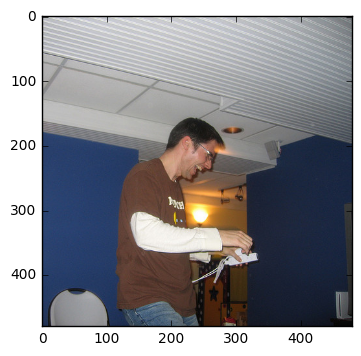

In [13]:
rng = get_best_range_of_instance(mask, img_id_to_image[524311])
img_raw = skimage.io.imread('data/train2014/' + img_id_to_image[524311]['file_name'])
img_crop = crop(rng[0], rng[1], rng[2], img_raw)
plt.imshow(img_crop)

## Create data set of pics with humans in it

In [238]:
def crop_and_save_wrapper(img_arg):
    return crop_seg_and_save(img_arg[0], img_arg[1])

def generate_arg(img_id_to_people, img_id_to_image):
    valid_id = set(img_id_to_people.keys()) & set(img_id_to_image.keys())
    for i in valid_id:
        yield img_id_to_people[i], img_id_to_image[i]

with Pool(7) as p:
    cnt = 0
    for _ in p.imap_unordered(crop_and_save_wrapper, generate_arg(img_id_to_people, img_id_to_image)):
        cnt += 1
        if cnt % 1000 == 0:
            print(cnt)
    print("Done:", cnt)

Process ForkPoolWorker-38:
Process ForkPoolWorker-37:
Process ForkPoolWorker-32:
Process ForkPoolWorker-31:
Process ForkPoolWorker-40:
Traceback (most recent call last):
Process ForkPoolWorker-39:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Process ForkPoolWorker-34:
Traceback (most recent call last):
Process ForkPoolWorker-33:
  File "/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-35:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process

KeyboardInterrupt: 

## Create data set of images without human it.

In [26]:
files_with_human = set(map(lambda x: x['file_name'], map(img_id_to_image.get, img_id_to_people.keys())))
img_id_no_human = set(img_id_to_image.keys()) - set(img_id_to_people.keys())

with Pool(7) as p:
    cnt = 0
    for _ in p.imap_unordered(crop_square_and_save, map(img_id_to_image.get, img_id_no_human)):
        cnt += 1
        if cnt % 1000 == 0:
            print(cnt)
    print("Done:", cnt)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


/usr/local/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: human_f/COCO_train2014_000000569697.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


/usr/local/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: human_f/COCO_train2014_000000105396.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


31000
32000
33000


/usr/local/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: human_f/COCO_train2014_000000377011.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


34000
35000
36000
37000
Done: 37609


In [32]:
imgs = []
labels = []
for img_file in glob.glob("data/human_t/*"):
    img_arr = scipy.ndimage.imread(img_file, mode="RGB")
    img_arr = scipy.misc.imresize(img_arr, [100, 100])
    imgs.append(img_arr)
    labels.append([1.0, 0.0])
    
for img_file in glob.glob("data/human_f/*"):
    img_arr = scipy.ndimage.imread(img_file, mode="RGB")
    img_arr = scipy.misc.imresize(img_arr, [100, 100])
    imgs.append(img_arr)
    labels.append([0.0, 1.0])

(100, 100, 3)


In [34]:
np.savez_compressed("human_with_label.npz",
                    imgs=np.array(imgs),
                    labels = np.array(labels, dtype=np.double))